In [1]:
import numpy as np
import pandas as pd
import sklearn as sklearn
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin,RegressorMixin
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import random

DEBUG = 'DEBUG'

np.__version__,pd.__version__,sklearn.__version__

('1.22.3', '1.4.2', '1.0.2')

In [138]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor


In [131]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import copy
import math

class GBXTRegressor(BaseEstimator,RegressorMixin):
  def __init__ (self,iteractions=5,algorithm=ExtraTreesRegressor
                ,algorithm_params={'n_estimators':25,'max_depth':2
                                   ,'max_samples':0.8,'bootstrap':True}
                ,learning_rate=0.01
               ):
    self.algorithm = algorithm
    self.iteractions = iteractions
    self.algorithm_params = algorithm_params
    self.models = []
    self.model_size_ = 0
    self.learning_rate = learning_rate
  
  def fit(self,X,y):
    yprev = y # actual
    ypred = 0 # predicted
    n = self.algorithm_params['n_estimators']
    params = copy.deepcopy(self.algorithm_params)
    l = 1

    #Boosting iteractions
    for i in range(self.iteractions):
      #print(DEBUG,n)
      if n < 2 : 
        model = DecisionTreeRegressor(max_depth=params['max_depth'])
      else: 
        model = self.algorithm(**params)
      yresid =  l*(yprev - ypred) # residual loss
      model.fit(X,yresid)
      self.models.append(model)
      yprev = yresid # update actual resid value
      ypred = model.predict(X) # update predictions
      self.model_size_ += n
      n = math.ceil(n/2) 
      params['n_estimators'] = n
      l = l*(1-self.learning_rate)
      

    return self
  
  def predict(self,X,y=None):
    ypred = sum(model.predict(X) for model in self.models)
    return ypred 

  def get_params(self, deep=True):
      # Return current parameters
      return {"iteractions": self.iteractions, "algorithm": self.algorithm
              , 'algorithm_params': self.algorithm_params, 'learning_rate': self.learning_rate }

  def set_params(self, **parameters):
      for parameter, value in parameters.items():
          setattr(self, parameter, value)
      return self

86

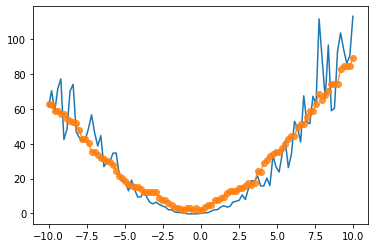

In [132]:
# create 1000 equally spaced points between -10 and 10
x = np.linspace(-10, 10, 100)
X = x.reshape(-1,1)

# calculate the y value for each element of the x vector
y = (x**2 + x )* (1-0.2*np.random.normal(0,1,100))

reg = GBXTRegressor(iteractions=40,learning_rate=0.1)
reg.fit(X,y)
ypred = reg.predict(X)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, ypred,'-o',label='GBXT',alpha=0.8)
reg.model_size_

GBXT R2:  0.9862685051488633
GBXT MAPE:  5.0319153640048615
SKLearn XT R2:  0.7280682215230861
SKLearn XT MAPE:  17.034989143748373
SKlearn GB R2:  0.9905147816404616
SKlean GB MAPE:  5.27389235814077
SKlearn RF R2:  0.8590114397774198
SKlean RF MAPE:  15.036134698803215
LGBM R2:  0.7147143639148414
LGBM MAPE:  6.912752849126771

TEST RESULTS: Estimators 100 ,max_depth 2
Ground Truth Poli Model Test: 0.17854003377831
GBXT MAPE Test: 1.0646550152432739
SKLearn XT MAPE Test: 21.52850896298155
SKLearn GB MAPE Test: 2.391868215610587
SKLearn RF MAPE Test: 15.955149062788573
LGBM MAPE Test: 0.8209084714035504


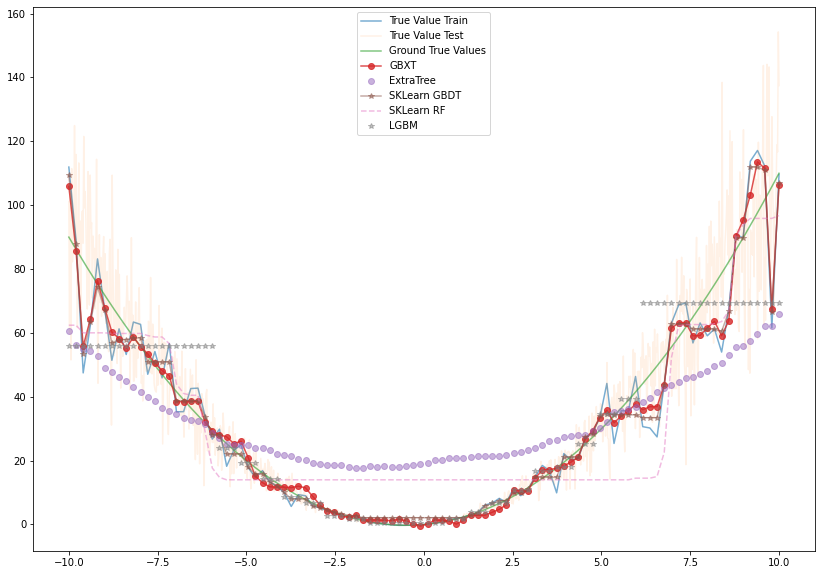

In [154]:
n = 20
reg = GBXTRegressor(n*2) # treinadas n Níveis de GB com 5 DT cada por XT. Total n*5 DT com dois níveis cada arvore
xt = ExtraTreesRegressor(n_estimators=n*5,max_depth=2) # Mesmo número de arvores treinadas n*5 DT e mesmo número de níveis
gb = GradientBoostingRegressor(n_estimators=n*5,max_depth=2) # Mesmo número de arvores treinadas n*5 DT e mesmo número de níveis
rf = RandomForestRegressor(n_estimators=n*5,max_depth=2) # Mesmo número de arvores treinadas n*5 DT e mesmo número de níveis
lgb = LGBMRegressor(n_estimators=n*5,max_depth=2)

# create 1000 equally spaced points between -10 and 10
x = np.linspace(-10, 10, 100)
X = x.reshape(-1,1)
xtst = np.linspace(-10, 10, 1000)
Xt = xtst.reshape(-1,1)

# calculate the y value for each element of the x vector
y = (x**2 + x )* (1-0.2*np.random.normal(0,1,100))
yt = (xtst**2 + xtst )* (1-0.2*np.random.normal(0,1,1000))
yg = (xtst**2 + xtst )

reg.fit(X,y)
ypred = reg.predict(X)

xt.fit(X,y)
ypred2 = xt.predict(X)

gb.fit(X,y)
ypred3 = gb.predict(X)

rf.fit(X,y)
ypred4 = rf.predict(X)

lgb.fit(X,y)
ypred5 = lgb.predict(X)

fig, ax = plt.subplots()
ax.plot(x, y, label='True Value Train',alpha=0.6)
ax.plot(xtst, yt, label='True Value Test',alpha=0.1)
ax.plot(xtst, yg, label='Ground True Values',alpha=0.6)
ax.plot(x, ypred,'-o',label='GBXT',alpha=0.8)
ax.plot(x, ypred2,'o',label='ExtraTree',alpha=0.5)
ax.plot(x, ypred3,'-*',label='SKLearn GBDT',alpha=0.5)
ax.plot(x, ypred4,'--',label='SKLearn RF',alpha=0.5)
ax.plot(x, ypred5,'*',label='LGBM',alpha=0.5)
ax.legend()
fig.set_size_inches(14, 10)


from sklearn.model_selection import cross_validate
scores = cross_validate(reg, X, y, cv=5,scoring=('r2', 'neg_mean_absolute_percentage_error'),return_train_score=True)
print('GBXT R2: ',np.mean(scores['train_r2']))
print('GBXT MAPE: ',np.mean(-scores['test_neg_mean_absolute_percentage_error']))

scores = cross_validate(xt, X, y, cv=5,scoring=('r2', 'neg_mean_absolute_percentage_error'),return_train_score=True)
print('SKLearn XT R2: ',np.mean(scores['train_r2']))
print('SKLearn XT MAPE: ',np.mean(-scores['test_neg_mean_absolute_percentage_error']))

from sklearn.model_selection import cross_validate
scores = cross_validate(gb, X, y, cv=5,scoring=('r2', 'neg_mean_absolute_percentage_error'),return_train_score=True)
print('SKlearn GB R2: ',np.mean(scores['train_r2']))
print('SKlean GB MAPE: ',np.mean(-scores['test_neg_mean_absolute_percentage_error']))

from sklearn.model_selection import cross_validate
scores = cross_validate(rf, X, y, cv=5,scoring=('r2', 'neg_mean_absolute_percentage_error'),return_train_score=True)
print('SKlearn RF R2: ',np.mean(scores['train_r2']))
print('SKlean RF MAPE: ',np.mean(-scores['test_neg_mean_absolute_percentage_error']))

from sklearn.model_selection import cross_validate
scores = cross_validate(lgb, X, y, cv=5,scoring=('r2', 'neg_mean_absolute_percentage_error'),return_train_score=True)
print('LGBM R2: ',np.mean(scores['train_r2']))
print('LGBM MAPE: ',np.mean(-scores['test_neg_mean_absolute_percentage_error']))

from sklearn.metrics import mean_absolute_percentage_error
print('\nTEST RESULTS: Estimators',n*5,',max_depth 2')

ypred = (xtst**2 + xtst )
print('Ground Truth Poli Model Test:',mean_absolute_percentage_error(yt,ypred))

ypred = reg.predict(Xt)
print('GBXT MAPE Test:',mean_absolute_percentage_error(yg,ypred))

ypred = xt.predict(Xt)
print('SKLearn XT MAPE Test:',mean_absolute_percentage_error(yg,ypred))

ypred = gb.predict(Xt)
print('SKLearn GB MAPE Test:',mean_absolute_percentage_error(yg,ypred))

ypred = rf.predict(Xt)
print('SKLearn RF MAPE Test:',mean_absolute_percentage_error(yg,ypred))

ypred = lgb.predict(Xt)
print('LGBM MAPE Test:',mean_absolute_percentage_error(yg,ypred))

In [129]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
model = DecisionTreeRegressor
n=5
m=0.8
params = {"n_estimators":n,"max_depth":2,"max_samples":m,"bootstrap":True}
params = {"max_depth":2}
X = x.reshape(-1,1)
X = x.reshape(-1,1)
tree_reg1 = model(**params)
tree_reg1.fit(X, y)
ypred1 = tree_reg1.predict(X)

In [216]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = model(**params)
tree_reg2.fit(X, y2)
ypred2 = tree_reg2.predict(X)

In [217]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = model(**params)
tree_reg3.fit(X, y3)
ypred3 = tree_reg3.predict(X)

In [218]:
y4 = y3 - tree_reg3.predict(X)
tree_reg4 = model(**params)
tree_reg4.fit(X, y4)
ypred4 = tree_reg4.predict(X)

In [219]:
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3,tree_reg4))

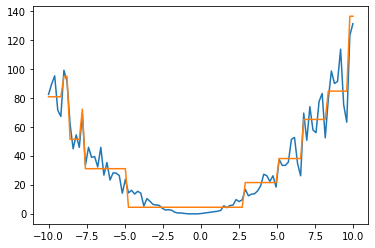

In [220]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, y_pred)

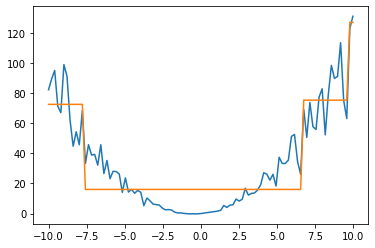

In [221]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, ypred1)

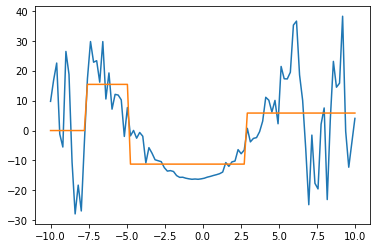

In [222]:
fig, ax = plt.subplots()
ax.plot(x, y2)
ax.plot(x, ypred2)

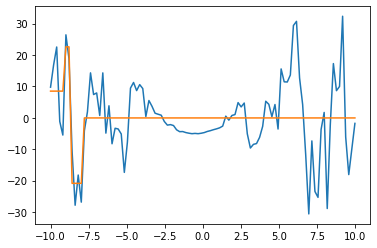

In [223]:
fig, ax = plt.subplots()
ax.plot(x, y3)
ax.plot(x, ypred3)

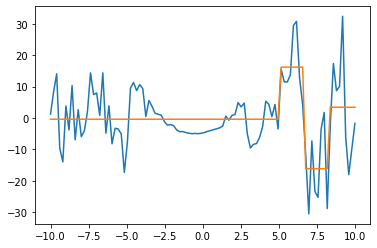

In [224]:
fig, ax = plt.subplots()
ax.plot(x, y4)
ax.plot(x, ypred4)

[0.92445607 0.89300037 0.82959609 0.89990934 0.929481  ]
[-1713.60312821   -37.71888815  -254.17915502   -64.86921897
 -1528.87801545]


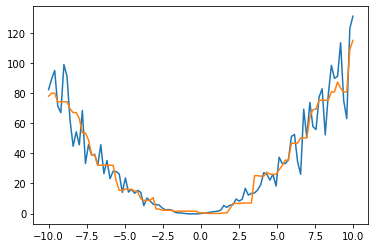

In [225]:
reg = GBXTRegressor()

reg.fit(X,y)
ypred = reg.predict(X)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, ypred)

from sklearn.model_selection import cross_validate
scores = cross_validate(reg, X, y, cv=5,scoring=('r2', 'neg_mean_squared_error'),return_train_score=True)
print(scores['train_r2'])
print(scores['test_neg_mean_squared_error'])